## 1. Important Libraries

In [1]:
import torch
from torch import nn,optim
import torchvision
from torchvision import datasets, transforms, models

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,precision_recall_fscore_support 

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 
import pandas as pd
import os
import random
import itertools

from torchinfo import summary
import seaborn as sns
from torch_lr_finder import LRFinder

from Dataset import covid_dataset
from Visualizations import plot_samples,plot_samples_with_predictions,plot_confusion
from TransferModel import Model
from Main import main,Test_ensemble,Get_predictions

## 2. Constants and Parameters

In [2]:
data_dir='./datasets/ThreeClasses_data'
num_classes=3
epochs=40
batch_size=16
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 3. Covid Dataset

### 3.1 Creating Train/Test Splits and DataLoaders without any data preprocessing or Transformations

In [3]:
Train_set ,Test_set ,Trainloader_, Testloader_= covid_dataset(data_dir,batch_size=batch_size,Transformation=False)

### 3.2 Exploring Dataset 

In [4]:
print("Train set:",len(Train_set))
print("Test set:",len(Test_set))

Train set: 1900
Test set: 742


#### 3.2.1 **Classes**

In [5]:
print(f"Dataset Classes: {Train_set.classes}")
print(f"Dataset Label: {Train_set.class_to_idx}")

Dataset Classes: ['COVID', 'NORMAL', 'PNEUMONIA']
Dataset Label: {'COVID': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


##### Classes Distribution

In [6]:
train_samplesize = pd.DataFrame.from_dict(
    {'PNEUMONIA': [len( [os.path.join(data_dir+'/train/NORMAL', filename) 
                     for filename in os.listdir(data_dir+'/train/PNEUMONIA')] )], 
     'COVID': [len([os.path.join(data_dir+'/train/PNEUMONIA', filename) 
                        for filename in os.listdir(data_dir+'/train/COVID')])],
    'NORMAL': [len([os.path.join(data_dir+'/train/PNEUMONIA', filename) 
                        for filename in os.listdir(data_dir+'/train/NORMAL')])]}
)
train_samplesize



,PNEUMONIA,COVID,NORMAL
0,700,500,700


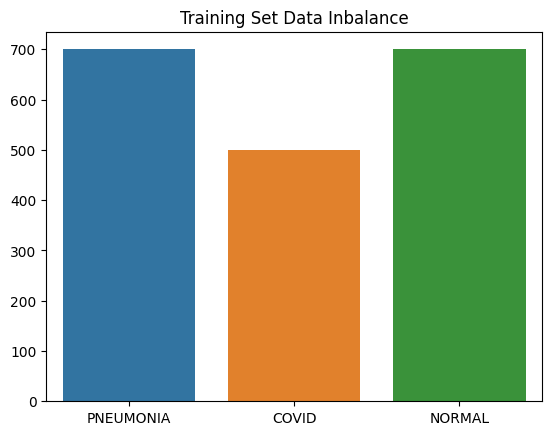

In [7]:
sns.barplot(data=train_samplesize).set_title('Training Set Data Inbalance')
plt.show()

#### 3.2.2 Input Tensor Information

**A sample of trainset is a tuple consists of image and class**

In [8]:
img,lbl=Train_set[0]

print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype} \n")
print(f"Image label: {lbl} : {lbl}")
print(f"Label datatype: {type(lbl)}")

Image shape: torch.Size([3, 361, 373])
Image datatype: torch.float32 

Image label: 0 : 0
Label datatype: <class 'int'>


 #### **3.2.3 Plotting random Samples with labels**

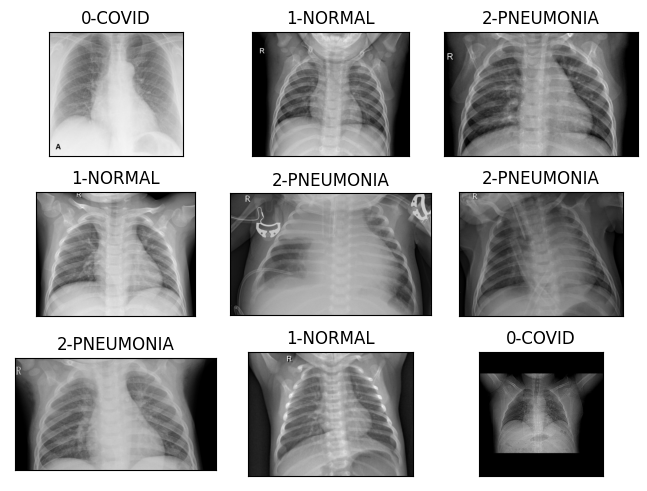

In [9]:
plot_samples(Train_set)

### 3.3 **Dataset with transformation**

In [10]:
Train_set_Aug ,Test_set_Aug ,Trainloader, Testloader= covid_dataset(data_dir,batch_size=batch_size,Transformation=True)


In [11]:
img,lbl=Train_set_Aug[0]

print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype} \n")
print(f"Image label: {lbl} : {lbl}")
print(f"Label datatype: {type(lbl)}")

Image shape: torch.Size([3, 224, 224])
Image datatype: torch.float32 

Image label: 0 : 0
Label datatype: <class 'int'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


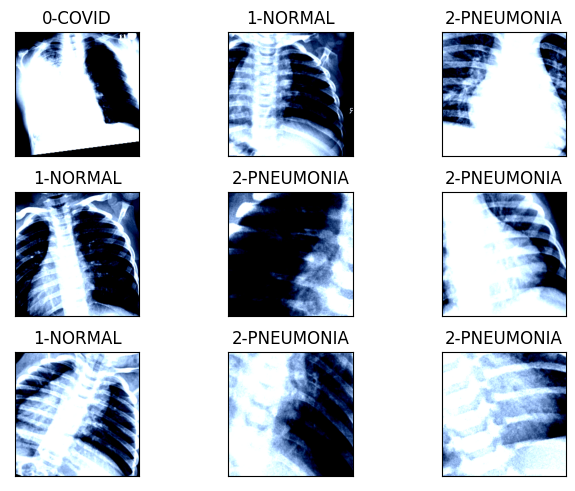

In [12]:
plot_samples(Train_set_Aug)

In [13]:
print(f"Total no. of batches in trainloader : {len(Trainloader)}")
print(f"Total no. of batches in testloader : {len(Testloader)}")

Total no. of batches in trainloader : 119
Total no. of batches in testloader : 47


## 4. Model

#### **Some Model Architectures:**
`Resnet18`
`resnet50`
`Mobilenet_v2`
`Shufflenet_v2`

In [14]:
models_arch=['resnet18','mobilenet_v2',"shufflenet_v2_x2_0"]

In [15]:
models={}
for model in models_arch:
    # Create Instances of Our Models
    models[model]=Model(model,num_classes=num_classes,device=device)
    
keys=list(models.keys())
keys

Using cache found in /home1/ece1/.cache/torch/hub/pytorch_vision_main
Using cache found in /home1/ece1/.cache/torch/hub/pytorch_vision_main
Using cache found in /home1/ece1/.cache/torch/hub/pytorch_vision_main


['resnet18', 'mobilenet_v2', 'shufflenet_v2_x2_0']

In [16]:
summary(models['shufflenet_v2_x2_0'], 
        (128,3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
Model (Model)                                 [128, 3, 224, 224]   [128, 3]             --                   Partial
├─ShuffleNetV2 (model)                        [128, 3, 224, 224]   [128, 3]             --                   Partial
│    └─Sequential (conv1)                     [128, 3, 224, 224]   [128, 24, 112, 112]  --                   False
│    │    └─Conv2d (0)                        [128, 3, 224, 224]   [128, 24, 112, 112]  (648)                False
│    │    └─BatchNorm2d (1)                   [128, 24, 112, 112]  [128, 24, 112, 112]  (48)                 False
│    │    └─ReLU (2)                          [128, 24, 112, 112]  [128, 24, 112, 112]  --                   --
│    └─MaxPool2d (maxpool)                    [128, 24, 112, 112]  [128, 24, 56, 56]    --                   --
│    └─Sequential (stage2)                    [128, 24, 56, 56]    [128, 244, 

## 5. Loss Function and Optimizers

In [17]:
loss_fn = nn.CrossEntropyLoss()

def Get_optimizer(model,opt="SGD",lr=3e-3):
    if opt=="SGD":
        return  optim.SGD(model.parameters(), lr=lr)
    elif opt=="Adam":
        return optim.Adam(model.parameters(), lr=lr)
    elif opt=="RMSprop":
        return optim.RMSprop(model.parameters(), lr=lr)

## 6. LR_Finder

In [18]:
def Get_LR(Trainloader,model,optimizer,loss_fn,device="cuda"):
    lr_finder = LRFinder(model, optimizer, loss_fn, device=device)
    lr_finder.range_test(Trainloader, end_lr=100, num_iter=100)
    lr_finder.plot() 
    lr_finder.reset()

## 8. Training and Testing

### 8.1 `Resnet18`

In [19]:
lr=1e-3

In [20]:
model1=models[keys[0]]
optimizer1=Get_optimizer(model1,opt="RMSprop",lr=lr)

main(model1,Trainloader,Testloader,loss_fn,
     optimizer1,lr=lr,name=(keys[0]+"_3class"),epochs=20,save_weights=True,scheduler_bol=True)

Ep[Train]1/20: 100%|█| 119/119 [00:43<00:00,  2.72it/s, loss=0.776242, acc=0.685
Ep[Train]2/20: 100%|█| 119/119 [00:41<00:00,  2.86it/s, loss=0.482889, acc=0.801
Ep[Train]3/20: 100%|█| 119/119 [00:41<00:00,  2.88it/s, loss=0.464698, acc=0.817
Ep[Train]4/20: 100%|█| 119/119 [00:41<00:00,  2.89it/s, loss=0.407952, acc=0.843
Ep[Train]5/20: 100%|█| 119/119 [00:41<00:00,  2.89it/s, loss=0.400447, acc=0.842
Ep[Train]6/20: 100%|█| 119/119 [00:41<00:00,  2.90it/s, loss=0.365299, acc=0.850
Ep[Train]7/20: 100%|█| 119/119 [00:41<00:00,  2.89it/s, loss=0.340716, acc=0.873
Ep[Train]8/20: 100%|█| 119/119 [00:40<00:00,  2.91it/s, loss=0.312193, acc=0.893
Ep[Train]9/20: 100%|█| 119/119 [00:41<00:00,  2.88it/s, loss=0.307385, acc=0.882
Ep[Train]10/20: 100%|█| 119/119 [00:41<00:00,  2.90it/s, loss=0.313680, acc=0.87
Ep[Train]11/20: 100%|█| 119/119 [00:40<00:00,  2.91it/s, loss=0.308148, acc=0.87
Ep[Train]12/20: 100%|█| 119/119 [00:41<00:00,  2.88it/s, loss=0.308380, acc=0.87
Ep[Train]13/20: 100%|█| 119/

### 8.2 `Mobilenet_v2`

In [21]:
model2=models[keys[1]]
optimizer2=Get_optimizer(model2,opt="RMSprop",lr=lr)

main(model2,Trainloader,Testloader,loss_fn,
     optimizer2,lr=lr,name=(keys[1]+"_3class"),epochs=20,save_weights=True,scheduler_bol=True)

Ep[Train]1/20: 100%|█| 119/119 [00:42<00:00,  2.78it/s, loss=0.737404, acc=0.730
Ep[Train]2/20: 100%|█| 119/119 [00:41<00:00,  2.87it/s, loss=0.463317, acc=0.816
Ep[Train]3/20: 100%|█| 119/119 [00:41<00:00,  2.88it/s, loss=0.391117, acc=0.853
Ep[Train]4/20: 100%|█| 119/119 [00:41<00:00,  2.87it/s, loss=0.394490, acc=0.853
Ep[Train]5/20: 100%|█| 119/119 [00:41<00:00,  2.88it/s, loss=0.403956, acc=0.843
Ep[Train]6/20: 100%|█| 119/119 [00:41<00:00,  2.89it/s, loss=0.344279, acc=0.873
Ep[Train]7/20: 100%|█| 119/119 [00:41<00:00,  2.88it/s, loss=0.318391, acc=0.876
Ep[Train]8/20: 100%|█| 119/119 [00:41<00:00,  2.87it/s, loss=0.336711, acc=0.870
Ep[Train]9/20: 100%|█| 119/119 [00:41<00:00,  2.87it/s, loss=0.356175, acc=0.862
Ep[Train]10/20: 100%|█| 119/119 [00:41<00:00,  2.87it/s, loss=0.344937, acc=0.87
Ep[Train]11/20: 100%|█| 119/119 [00:41<00:00,  2.88it/s, loss=0.321480, acc=0.87
Ep[Train]12/20: 100%|█| 119/119 [00:41<00:00,  2.90it/s, loss=0.351688, acc=0.86
Ep[Train]13/20: 100%|█| 119/

### 8.3 `shufflenet_v2`

In [22]:
model3=models[keys[2]]
optimizer3=Get_optimizer(model3,opt="RMSprop",lr=lr)

main(model3,Trainloader,Testloader,loss_fn,
     optimizer3,lr=lr,name=(keys[2]+"_3class"),scheduler_bol=True,epochs=20,save_weights=True)

Ep[Train]1/20: 100%|█| 119/119 [00:40<00:00,  2.94it/s, loss=0.590918, acc=0.779
Ep[Train]2/20: 100%|█| 119/119 [00:40<00:00,  2.95it/s, loss=0.339631, acc=0.874
Ep[Train]3/20: 100%|█| 119/119 [00:40<00:00,  2.94it/s, loss=0.307167, acc=0.892
Ep[Train]4/20: 100%|█| 119/119 [00:40<00:00,  2.94it/s, loss=0.301264, acc=0.889
Ep[Train]5/20: 100%|█| 119/119 [00:40<00:00,  2.94it/s, loss=0.274576, acc=0.899
Ep[Train]6/20: 100%|█| 119/119 [00:40<00:00,  2.96it/s, loss=0.246320, acc=0.914
Ep[Train]7/20: 100%|█| 119/119 [00:40<00:00,  2.94it/s, loss=0.240600, acc=0.911
Ep[Train]8/20: 100%|█| 119/119 [00:40<00:00,  2.95it/s, loss=0.226217, acc=0.917
Ep[Train]9/20: 100%|█| 119/119 [00:40<00:00,  2.96it/s, loss=0.230369, acc=0.913
Ep[Train]10/20: 100%|█| 119/119 [00:40<00:00,  2.94it/s, loss=0.240673, acc=0.90
Ep[Train]11/20: 100%|█| 119/119 [00:40<00:00,  2.95it/s, loss=0.219019, acc=0.92
Ep[Train]12/20: 100%|█| 119/119 [00:40<00:00,  2.94it/s, loss=0.220028, acc=0.91
Ep[Train]13/20: 100%|█| 119/

## 9. Models Ensambling

### 9.2 Resnet18 + Mobilenet

In [23]:
Test_loss , Test_acc,lbl_ensemble1,pred_ensemble1= Test_ensemble(model1,model2, Testloader, loss_fn,device='cuda')

Epoch[Test]1/1: 100%|█| 47/47 [00:12<00:00,  3.67it/s, loss=0.588693, acc=0.8621


### 9.3 Resnet18 + Shufflenet

In [24]:
Test_loss , Test_acc,lbl_ensemble2,pred_ensemble2= Test_ensemble(model1,model3, Testloader, loss_fn)

Epoch[Test]1/1: 100%|█| 47/47 [00:12<00:00,  3.71it/s, loss=0.474224, acc=0.8794


### 9.6 Mobilenet+ Shufflenet

In [25]:
Test_loss , Test_acc,lbl_ensemble4,pred_ensemble4= Test_ensemble(model2,model3, Testloader, loss_fn)

Epoch[Test]1/1: 100%|█| 47/47 [00:12<00:00,  3.66it/s, loss=0.612834, acc=0.8475


#### Ensemble 2 has highest accuracy `88%` with least error

## 10. Output Visualization for Best Model `(Ensemble 3)`

### 10.1 Confusion Matrix

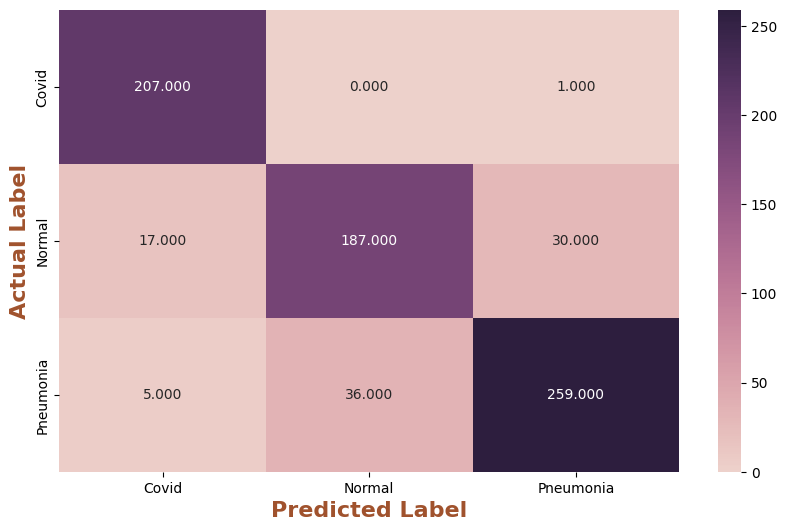

In [26]:
plot_confusion(lbl_ensemble2,pred_ensemble2,"3class_conf_noNorm",num_classes=3,Normalize=False)

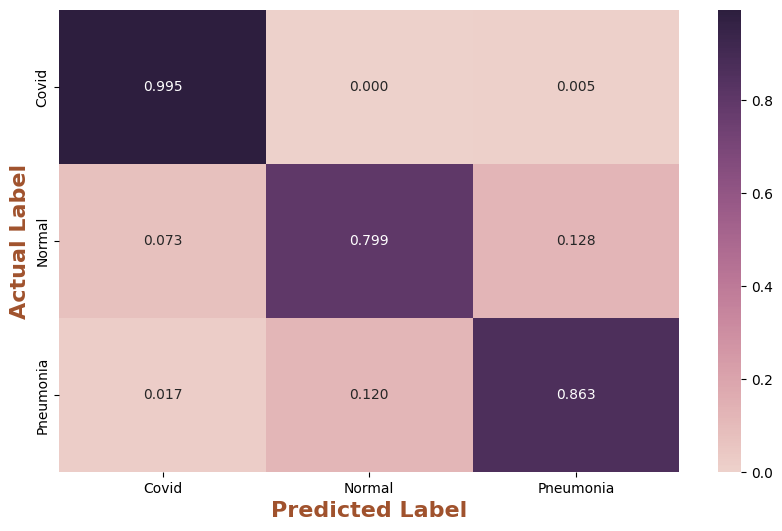

In [27]:
plot_confusion(lbl_ensemble2,pred_ensemble2,"3class_conf_Norm",num_classes=3,Normalize=True)

### 10.2 Classification Metrics

In [29]:
Report=classification_report(lbl_ensemble2,pred_ensemble2,digits=4)
print(Report)

              precision    recall  f1-score   support

           0     0.9039    0.9952    0.9474       208
           1     0.8386    0.7991    0.8184       234
           2     0.8931    0.8633    0.8780       300

    accuracy                         0.8801       742
   macro avg     0.8785    0.8859    0.8812       742
weighted avg     0.8789    0.8801    0.8786       742



### 10.3 Plot Prediction VS Actual Labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


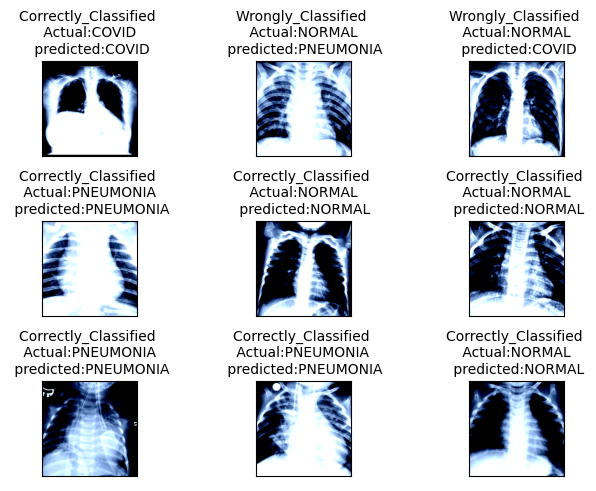

In [32]:
plot_samples(Test_set_Aug,preds=pred_ensemble2)

### 10.4 Plot Missclassified Samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


89


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


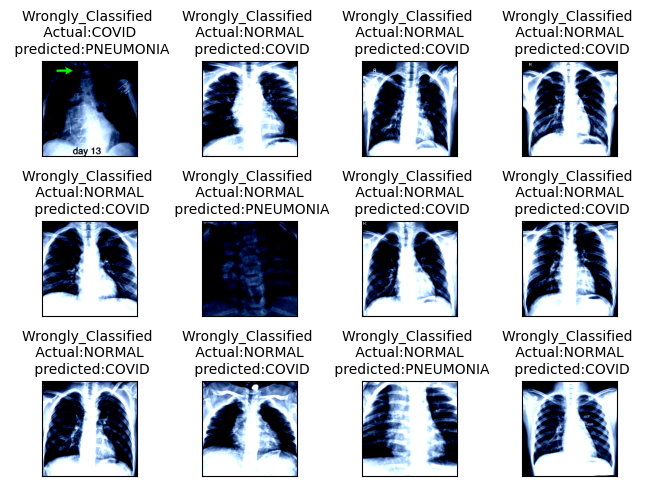

In [37]:
def plot_misclassified(split_set,preds):

    idx_to_class = {split_set.class_to_idx[k]: k for k in split_set.class_to_idx}
    misclassified=[]
    #figure, ax = plt.subplots(3, 3,constrained_layout = True)

    for idx in range(len(split_set)):
        if split_set[idx][1]!=preds[idx]:
            check="Wrongly_Classified"
            #print (idx)
            misclassified.append (idx)
    
    print(len(misclassified))
    figure, ax = plt.subplots(3,4 ,constrained_layout = True)
    missclass=misclassified[:13]
    k=0
    for i in range(3):
        for j in range (4):
            ax[i,j].imshow(split_set[missclass[k]][0].permute(1,2,0))
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].set_title(f"{check} \n Actual:{idx_to_class[split_set[missclass[k]][1]]} \n predicted:{idx_to_class[preds[missclass[k]]]}"
                           , fontsize=10)
            k+=1
        
plot_misclassified(Test_set_Aug,preds=pred_ensemble2)